# Online EdX experiment evaluation
A/B experiment was conducted on [CaltechDelftX: QuCryptox Quantum cryptography](https://courses.edx.org/courses/course-v1:CaltechDelftX+QuCryptox+3T2016) MOOC course offered by **Caltech University** and **TU Delft** at **EdX platform**. In this document, we are evaluating our proposed **question routing (recommendation of new questions) framework**. Users were split into three groups:

1. Question recommendation group *with educational-context*. Further reffered as **1.Educational context** 
2. Baseline group - question recommendation without considering educational-context. Further reffered as **2.Baseline**.   
3. Control group without question recommendation. Further reffered as **3.Control**

Please notice that users in both 1.Educational context group and 2. Baseline group have question recommendation. However, the method for generating recommendations in 2. Baseline group is not considering educational features (grades, knowledge gap, portion of seen lectures within categories in the online course, portion of seen questions within categories in CQA system, average activity in the online course and lecture freshness). 

Course lasted 11 weeks from 3th October 2016(week \#0) to 20th December 2016(week \#10). Online experiment started 14th November 2016 (start of week \#6). Welcome category where student greet themselves is not considered (category_id = 2). Analysed data are from period two weeks before (26th September 2016) and after (2nd January 2017) course. Therefore, period before and during online experiments are equal (both lasting 7 weeks).

Recommendation was delivered to user by notification:
![notification](images/askalot-notification.PNG)

And all recommendations for a user were also shown on the dashboard:
![dashboard recommendation](images/dashboard-rec.PNG)

In [1]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import psycopg2 as pg
import pandas.io.sql as psql
import matplotlib
matplotlib.style.use('ggplot')
from IPython.display import display
import scipy.stats as stats
from matplotlib.ticker import FormatStrFormatter

# graphics setup
%matplotlib inline
sns.set(color_codes=True)
sns.set_context("paper")
sns.set(font='serif')
sns.set_style("white", {
    "font.family": "serif",
    "font.serif": ["Times", "Palatino", "serif"]
})

# set up connection to the database
connection = pg.connect(database="askalot_edx_development", user="postgres", port=5432, 
                        host="localhost", password="")

## Users in recommendation groups are distributed evenly 

Users were sorted according to their answers count at the start of the online experiment. Subsequently, they were divided to groups by modulo operation of their order.

Pseudocode:
```
Sort users according to their answers count.
for i in lenght(sorted_users):
      ab_group[(i % 3) +1] <- sorted_users[i] 
```

In [2]:
ab_groups =  psql.read_sql("""SELECT id as ab_group_id, value as "Name" FROM ab_groups""", connection)
user_groups = psql.read_sql("""SELECT g.id, g.value as "Name", COUNT(*) as "User count" FROM ab_groupings ab
                         JOIN ab_groups g ON g.id=ab.ab_group_id GROUP BY g.id ORDER BY g.id""", connection)
user_groups

,id,Name,User count
0,1,1.Educational context,1306
1,2,2.Baseline,1306
2,3,3.Control,1306


Users who signed up for the course during online experiment did not get assigned to any group and are not considered in evaluation.

## Question routing recommended 132 questions during online experiment
Each question was recommended to both 10 most suitable users from educational-context group and to 10 most suitable users from group without educational context. 

In [3]:
answers_count = psql.read_sql("""
                                SELECT g.id, g.value, COUNT(DISTINCT(n.resource_id)) AS "Total number of recommended questions" 
                                FROM notifications as n 
                                JOIN ab_groupings ab ON ab.user_id = n.recipient_id 
                                JOIN ab_groups g ON g.id=ab.ab_group_id
                                WHERE n.action = 'recommendation'
                                GROUP BY g.id
                              """, connection)
rec_count = psql.read_sql("""
                                SELECT g.id, COUNT(DISTINCT(n.id)) AS "Total number of generated recommendations" 
                                FROM notifications as n 
                                JOIN ab_groupings ab ON ab.user_id = n.recipient_id 
                                JOIN ab_groups g ON g.id=ab.ab_group_id
                                WHERE n.action = 'recommendation'
                                GROUP BY g.id
                              """, connection)
rec_count = pd.merge(answers_count, rec_count, on="id", how='inner')
rec_count[['value', 'Total number of recommended questions', 'Total number of generated recommendations']]

,value,Total number of recommended questions,Total number of generated recommendations
0,1.Educational context,132,1320
1,2.Baseline,132,1320


## Recommendation click-through rate was more than 20%
Recommendation was sent to users by two channels:

1. as a notification in Askalot CQA system
2. personlized recommended list of questions is shown on user dashboard 

Click-through rate is computed as portion of read recommendations to total number of recommendations.

,Absolute count,Unique users,Total CTR
0,535,75,0.202652


,value,Unique users,CTR
0,1.Educational context,40,0.114394
1,2.Baseline,35,0.088258


,From dashboard,Absolute count,Unique users,Portion of CTR
0,False,466,61,0.871028
1,True,69,25,0.128972


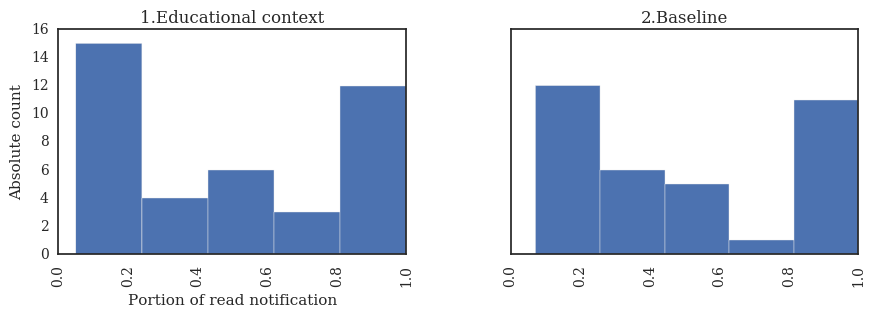

In [4]:
ctr = psql.read_sql("""   
    SELECT COUNT(n.recipient_id) as "Absolute count", COUNT(DISTINCT(n.recipient_id)) AS "Unique users", CAST(COUNT(n.id) AS FLOAT) / (SELECT COUNT(*) FROM notifications WHERE action= 'recommendation') as "Total CTR"
    FROM notifications as n WHERE n.action= 'recommendation' AND n.unread = FALSE
    """,connection)
display(ctr)

ctr_by_groups = psql.read_sql("""
    SELECT g.value, COUNT(DISTINCT(n.recipient_id)) AS "Unique users", CAST(COUNT(n.recipient_id) AS FLOAT) / (SELECT COUNT(*) FROM notifications WHERE action= 'recommendation') as "CTR"
    FROM notifications as n 
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id
    JOIN ab_groups g ON g.id=ab.ab_group_id
    WHERE n.action= 'recommendation' AND n.unread = FALSE
    GROUP BY g.id ORDER BY g.id
    """, connection)
display(ctr_by_groups)

ctr_from_dashboard = psql.read_sql("""   
    SELECT n.from_dashboard AS "From dashboard", COUNT(n.recipient_id) as "Absolute count", COUNT(DISTINCT(n.recipient_id)) AS "Unique users", CAST(COUNT(n.recipient_id) AS FLOAT) / (SELECT COUNT(*) FROM notifications WHERE action= 'recommendation' AND unread=FALSE) as "Portion of CTR" 
    FROM notifications as n WHERE n.action= 'recommendation' AND n.unread = FALSE GROUP BY n.from_dashboard """,connection)
display(ctr_from_dashboard)

ctr_by_users = psql.read_sql("""
    SELECT g.value, n.recipient_id, COUNT(n.id)::float / (SELECT COUNT(*) FROM notifications x WHERE x.action= 'recommendation' AND n.recipient_id=x.recipient_id) AS "portion"
    FROM notifications as n 
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id
    JOIN ab_groups g ON g.id=ab.ab_group_id
    WHERE n.action= 'recommendation' AND n.unread = FALSE
    GROUP BY g.id, n.recipient_id ORDER BY g.id, COUNT(n.id) DESC
    """, connection)

ax = ctr_by_users.hist(by='value',column = 'portion', bins=5, layout=(1,2), sharey=True, figsize=(10, 3))
ax[0].set(xlabel='Portion of read notification', ylabel="Absolute count")

Group with educational context has better CTR by 2.5% and it has 4 more unique users who read any recommendation. 

From the histograms above, it is possible to see that both groups have portion of users who read all of the recommendations (possibly contains empty-inbox users).

Notifications were 7 times more efficient for sending a recommendation than list of questions at the dasboard.

### Question routing with educational-context has better recommendation success rate
Recommendation success rate is portion of recommendations which were answered or commented by the recipient of the recommendation to total number of recommended questions.

In [5]:
answers_success_rec = psql.read_sql("""
    SELECT ab.ab_group_id, n.id as n_id, n.created_at as n_created_at, n.unread, n.read_at, n.from_dashboard, q.title, q.author_id, q.text, q.created_at, a.id, a.author_id, a.text, a.created_at as r_created_at, a.votes_difference
    FROM notifications as n INNER JOIN questions q ON q.id = n.resource_id INNER JOIN answers a ON n.recipient_id = a.author_id AND q.id=a.question_id 
    INNER JOIN ab_groupings ab ON ab.user_id = n.recipient_id WHERE n.action= 'recommendation'
    """,connection)

comments_success_rec = psql.read_sql("""
    SELECT ab.ab_group_id, n.id as n_id, n.created_at as n_created_at, n.unread, n.read_at, n.from_dashboard, q.title, q.author_id, q.text, q.created_at, c.id, c.author_id, c.text, c.created_at as r_created_at, 0 as votes_difference
    FROM notifications as n INNER JOIN questions q ON q.id = n.resource_id INNER JOIN comments c ON (n.recipient_id = c.author_id AND q.id=c.commentable_id AND c.commentable_type = 'Shared::Question') 
    INNER JOIN ab_groupings ab ON ab.user_id = n.recipient_id WHERE n.action= 'recommendation'
    """,connection)

success_rec = pd.concat([answers_success_rec, comments_success_rec])
success_rec = pd.merge(success_rec, ab_groups, on="ab_group_id")

success_rec_by_groups = success_rec.groupby('ab_group_id')['n_id'].count().to_frame(name = 'success_count').reset_index()
success_rec_by_groups = pd.merge(success_rec_by_groups, rec_count, left_on='ab_group_id', right_on="id", how='inner')
success_rec_by_groups['success_portion'] = success_rec_by_groups['success_count'] / success_rec_by_groups['Total number of recommended questions']
success_rec_by_groups.rename(columns={'success_portion': 'Recommendation success rate'}, inplace=True)
display(success_rec_by_groups[['value', 'success_count', 'Total number of generated recommendations', 'Total number of recommended questions', 'Recommendation success rate']])
print("Effect size %.2f%%" % ((success_rec_by_groups.ix[0]['Recommendation success rate'] - success_rec_by_groups.ix[1]['Recommendation success rate'])*100))

,value,success_count,Total number of generated recommendations,Total number of recommended questions,Recommendation success rate
0,1.Educational context,22,1320,132,0.166667
1,2.Baseline,6,1320,132,0.045455


Effect size 12.12%


Educational context is better by 12.12% in recommendation success rate in comparison with baseline approach. It can be explained by:

- more accurate recommendation
- large part of users in baseline group dropped out from the course

## Counts before and during online experiment
It is important to mention that online experiment was conducted from week \#6 to the end of the course (week \#10), i.e. for the period of 5 weeks during the course. In comparison, the period before the online experiment lasted from week \#0 to week \#5 inclusive, i.e. for the period of 6 weeks. Absolute counts are nearly doubled in most of the measured metrics which is caused by:
- not equal periods
- the course was getting harder each week and less users stayed active which is natural phenomenon of the MOOC course

### Question counts before and during online experiment

In [6]:
questions_end = psql.read_sql("SELECT q.author_id, ab.ab_group_id FROM questions q JOIN ab_groupings ab ON q.author_id = ab.user_id "+
                          "WHERE q.created_at >= '2016-11-14' AND q.created_at <= '2017-01-02' AND q.deleted=false", connection)
questions_start = psql.read_sql("SELECT q.author_id, ab.ab_group_id FROM questions q JOIN ab_groupings ab ON q.author_id = ab.user_id "+
                          "WHERE q.created_at < '2016-11-14' AND q.created_at >= '2016-09-26' AND q.deleted=false", connection)

print("Questions absolute counts:")
print("\tbefore online experiment: \t%d" % questions_start.shape[0])
print("\tduring online experiment: \t%d" % questions_end.shape[0])

Questions absolute counts:
	before online experiment: 	165
	during online experiment: 	116


Note: Deletion of some questions by users might cause the difference between recommended questions and total number of questions during online experiment.  

### Answers count before and during online experiment

In [7]:
answers_end = psql.read_sql("SELECT a.author_id, ab.ab_group_id, q.id FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id "+
                          "JOIN questions q ON q.id=a.question_id WHERE a.created_at >= '2016-11-14' AND q.created_at <= '2017-01-02' AND q.deleted=false", connection)
answers_start = psql.read_sql("SELECT a.author_id, ab.ab_group_id, q.id FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id "+
                          "JOIN questions q ON q.id=a.question_id WHERE a.created_at < '2016-11-14' AND q.created_at >= '2016-09-26' AND q.deleted=false", connection)

print("Answers absolute counts:")
print("\tbefore online experiment: \t%d" % answers_start.shape[0])
print("\tduring online experiment: \t%d" % answers_end.shape[0])

Answers absolute counts:
	before online experiment: 	187
	during online experiment: 	146


### Comments count before and during online experiment

In [8]:
comments_end = psql.read_sql("SELECT c.author_id, ab.ab_group_id FROM comments c JOIN ab_groupings ab ON c.author_id = ab.user_id "+
                          "WHERE c.created_at >= '2016-11-14' AND c.created_at <= '2017-01-02' AND c.deleted=false", connection)
comments_start = psql.read_sql("SELECT c.author_id, ab.ab_group_id FROM comments c JOIN ab_groupings ab ON c.author_id = ab.user_id "+
                          "WHERE c.created_at < '2016-11-14' AND c.created_at >= '2016-09-26' AND c.deleted=false", connection)

print("Coments absolute counts:")
print("\tbefore online experiment: \t%d" % comments_start.shape[0])
print("\tduring online experiment: \t%d" % comments_end.shape[0])

Coments absolute counts:
	before online experiment: 	278
	during online experiment: 	175


### Course interaction before and during online experiment

Interaction with the course means browsing the course content. Limitations: some users have blocked Javascript.

In [9]:
interaction_end = psql.read_sql("SELECT l.lister_id, ab.ab_group_id FROM lists l JOIN ab_groupings ab ON l.lister_id = ab.user_id "+
                          "WHERE l.created_at >= '2016-11-14'  AND l.created_at <= '2017-01-02'", connection)
interaction_start = psql.read_sql("SELECT l.lister_id, ab.ab_group_id FROM lists l JOIN ab_groupings ab ON l.lister_id = ab.user_id "+
                          "WHERE l.created_at < '2016-11-14' AND l.created_at >= '2016-09-26'", connection)

print("Course interactions:")
print("\tbefore online experiment: \t%d" % interaction_start.shape[0])
print("\tduring online experiment: \t%d" % interaction_end.shape[0])

print("Unique users interacting in the course:")
print("\tbefore online experiment: \t%d" % interaction_start['lister_id'].nunique())
print("\tduring online experiment: \t%d" % interaction_end['lister_id'].nunique())

Course interactions:
	before online experiment: 	55654
	during online experiment: 	58562
Unique users interacting in the course:
	before online experiment: 	2439
	during online experiment: 	903


Unique users during online course decreased by 60%. Even with the decrease in active users the number of interactions during experiment with the course or CQA system increased.

## Groups with question recommendation have more question views than control group which indicates higher activity in CQA system for groups with recommendation 

Question views:
	before online experiment: 	 9141
	during online experiment: 	 8213


ab_group
1.Educational context    3291
2.Baseline               3443
3.Control                1479
Name: viewer_id, dtype: int64

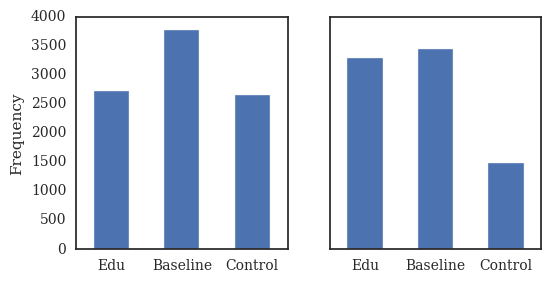

In [10]:
# read questions and filter columns
views_end = psql.read_sql("SELECT v.viewer_id, ab.ab_group_id, g.value AS ab_group FROM views v JOIN ab_groupings ab ON v.viewer_id = ab.user_id "+
                          "JOIN ab_groups g ON g.id=ab.ab_group_id "+
                          "WHERE v.created_at >= '2016-11-14' AND v.created_at <= '2017-01-02'", connection)
views_start = psql.read_sql("SELECT v.viewer_id, ab.ab_group_id, g.value AS ab_group FROM views v JOIN ab_groupings ab ON v.viewer_id = ab.user_id "+
                            "JOIN ab_groups g ON g.id=ab.ab_group_id "+
                            "WHERE v.created_at < '2016-11-14' AND v.created_at >= '2016-09-26'", connection)
print("Question views:")
print("\tbefore online experiment: \t%5.d" % views_start.shape[0])
print("\tduring online experiment: \t%5.d" % views_end.shape[0])


# Histogram views before
views_by_groups = views_start.groupby('ab_group')["viewer_id"].count()

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,3))
#  title="Question views before online experiment",
views_by_groups.plot(kind="bar", ax = ax1, rot=0)
ax1.set_xticklabels(["Edu", "Baseline", "Control"])
ax1.set(xlabel='', ylabel='Frequency')

# Histogram views during
views_by_groups = views_end.groupby('ab_group')["viewer_id"].count()

# title="Question views during online experiment"
views_by_groups.plot(kind="bar", ax=ax2, rot=0)
ax2.set(xlabel='', ylabel='Frequency')
ax2.set_xticklabels(["Edu", "Baseline", "Control"])
fig.set_size_inches(6, 3)
fig.savefig('questions-views.eps', format='eps')

views_by_groups

### 23% of baseline group contributors remained contributing during online experiment
Comparing contributing users (answering, commenting) before the online experiment and during the online experiment.

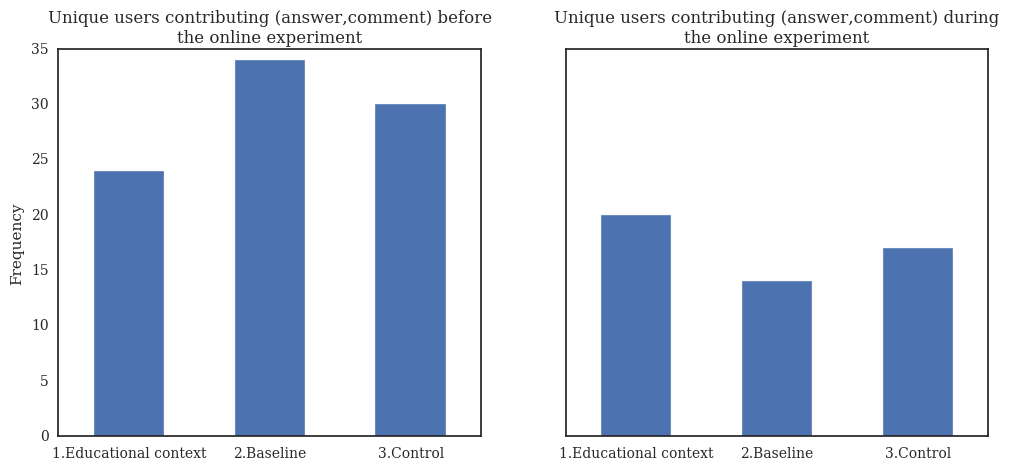

In [11]:
contributing_users_start = psql.read_sql("""
    SELECT DISTINCT(a.author_id), a.ab_group_id, g.value AS ab_group FROM
    ((SELECT a.author_id, ab.ab_group_id FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id
    JOIN questions q ON q.id=a.question_id JOIN ab_groups g ON g.id=ab.ab_group_id
    WHERE a.created_at < '2016-11-14' AND a.created_at >= '2016-09-26')
    UNION ALL
    (SELECT c.author_id, ab.ab_group_id FROM comments c JOIN ab_groupings ab ON c.author_id = ab.user_id
    WHERE c.created_at < '2016-11-14' AND c.created_at >= '2016-09-26')
    ) as a
    JOIN ab_groups g ON g.id=a.ab_group_id
    """, connection)

contributing_users_during = psql.read_sql("""
    SELECT DISTINCT(a.author_id), a.ab_group_id, g.value AS ab_group FROM
    ((SELECT a.author_id, ab.ab_group_id FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id
    JOIN questions q ON q.id=a.question_id
    WHERE a.created_at >= '2016-11-14' AND a.created_at <= '2017-01-02')
    UNION ALL
    (SELECT c.author_id, ab.ab_group_id FROM comments c JOIN ab_groupings ab ON c.author_id = ab.user_id
    WHERE c.created_at >= '2016-11-14' AND c.created_at <= '2017-01-02')
    ) as a
    JOIN ab_groups g ON g.id=a.ab_group_id
    """, connection)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
contributing_users_start.groupby('ab_group')["author_id"].count().plot(kind="bar", ax=ax1, title="Unique users contributing (answer,comment) before\nthe online experiment", rot=0)
ax1.set(xlabel='', ylabel='Frequency')
contributing_users_during.groupby('ab_group')["author_id"].count().plot(kind="bar", ax=ax2, title="Unique users contributing (answer,comment) during\nthe online experiment", rot=0)
ax2.set(xlabel='', ylabel='Frequency')

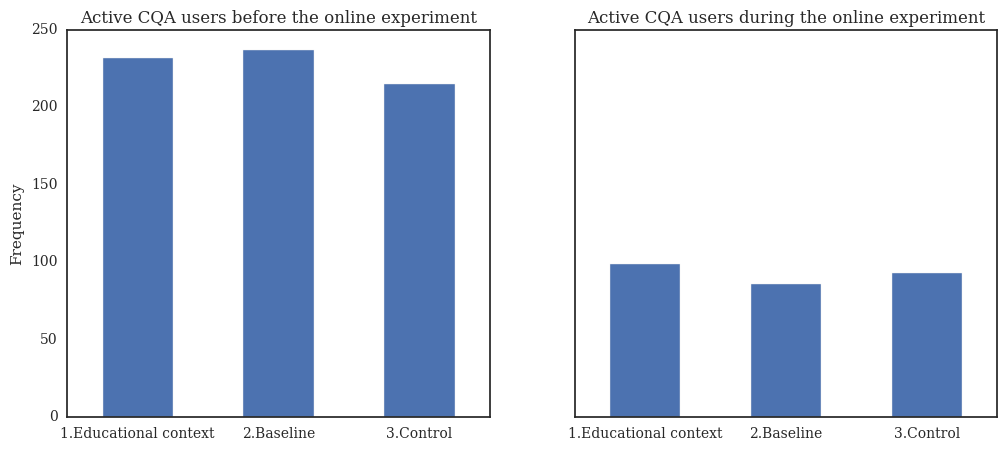

In [12]:
cqa_users_start = psql.read_sql("""
    SELECT DISTINCT(a.initiator_id), ab.ab_group_id, g.value AS ab_group FROM activities a
    JOIN ab_groupings ab ON ab.user_id=a.initiator_id
    JOIN ab_groups g ON g.id=ab.ab_group_id
    WHERE a.resource_type NOT IN ('Shared::List')
    AND a.created_at >= '2016-09-26' AND a.created_at < '2016-11-14' 
    """, connection)
cqa_users_end = psql.read_sql("""
    SELECT DISTINCT(a.initiator_id), ab.ab_group_id, g.value AS ab_group FROM activities a
    JOIN ab_groupings ab ON ab.user_id=a.initiator_id
    JOIN ab_groups g ON g.id=ab.ab_group_id
    WHERE a.resource_type NOT IN ('Shared::List')
    AND a.created_at >= '2016-11-14' AND a.created_at <= '2017-01-02' 
    """,connection)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
cqa_users_start.groupby('ab_group')["initiator_id"].count().plot(kind="bar", ax=ax1, title="Active CQA users before the online experiment", rot=0)
ax1.set(xlabel='', ylabel='Frequency')
cqa_users_end.groupby('ab_group')["initiator_id"].count().plot(kind="bar", ax=ax2, title="Active CQA users during the online experiment", rot=0)
ax2.set(xlabel='', ylabel='Frequency')

In [13]:
# Load grades csv
grades = pd.read_csv('grades2.csv', na_values=['Not Attempted'])
# Active students before online experiment
grades_before = grades.filter(regex=("Email|Lab [1-5]:|Homework [1-5]:|Quizzes \d*: [1-5].*"))
grades_before.fillna(0, inplace=True)
mooc_active_before = grades_before[(grades_before.ix[:,1:].T != 0).any()]
print('Active students in MOOC who did any quizz, assignment or lab.')
print("Active students in MOOC before online experiment: \t%d" % mooc_active_before.shape[0])
# Active students durign online experiment
grades_after = grades.filter(regex=("Email|Lab ([6-9]{1}|\d\d):|Homework ([6-9]{1}|\d\d):|Quizzes \d*: ([6-9]{1}|\d\d).*"))
grades_after.fillna(0, inplace=True)
mooc_active_after = grades_after[(grades_after.ix[:,1:].T != 0).any()]
print("Active students in MOOC during online experiment: \t%d" % mooc_active_after.shape[0])

users = psql.read_sql("""
    SELECT u.email, ab.user_id, ab.ab_group_id
    FROM users u
    JOIN ab_groupings ab ON ab.user_id=u.id""", connection)
users = pd.merge(users, ab_groups, on="ab_group_id")

# Join on users table
mooc_users_before = pd.merge(users, mooc_active_before, left_on='email', right_on='Email', how='right')
mooc_users_after = pd.merge(users, mooc_active_after, left_on='email', right_on='Email')

# Filter columns
mooc_users_before[['email','user_id','ab_group_id', 'Name']]
mooc_users_after[['email','user_id','ab_group_id', 'Name']]
None

Active students in MOOC who did any quizz, assignment or lab.
Active students in MOOC before online experiment: 	726
Active students in MOOC during online experiment: 	212


In [14]:
# Create before and during dataframe with answer, question and comments counts

# Before
# questions
question_by_groups = questions_start.groupby('ab_group_id')["author_id"].count()
start_df = question_by_groups.to_frame(name = 'questions_count').reset_index()
# answers
answers_by_groups = answers_start.groupby('ab_group_id')["author_id"].count()
temp = answers_by_groups.to_frame(name = 'answers_count').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# comments
comments_by_groups = comments_start.groupby('ab_group_id')["author_id"].count()
temp = comments_by_groups.to_frame(name = 'comments_count').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# Interactions
interactions_by_groups = interaction_start.groupby('ab_group_id')["lister_id"].count()
temp = interactions_by_groups.to_frame(name = 'interactions_count').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# Unique users interacting
interactions_by_groups = interaction_start.groupby('ab_group_id')["lister_id"].nunique()
temp = interactions_by_groups.to_frame(name = 'unique_users_interacting').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# Unique users contributing
contributing_users_by_groups = contributing_users_start.groupby(['ab_group_id', 'ab_group'])["author_id"].nunique()
temp = contributing_users_by_groups.to_frame(name = 'unique_users_contributing').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# Active users CQA
cqa_users_by_groups = cqa_users_start.groupby('ab_group_id')["initiator_id"].nunique()
temp = cqa_users_by_groups.to_frame(name = 'unique_users_using_CQA').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# Users count - divided equally at the beggining
start_df = pd.merge(start_df, user_groups[['id','User count']], left_on='ab_group_id', right_on="id", how='inner')
# Active MOOC users
mooc_users_by_groups = mooc_users_before.groupby('ab_group_id')["user_id"].nunique()
temp = mooc_users_by_groups.to_frame(name = 'unique_users_mooc').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')


print("Statistics for groups before online experiment")
display(start_df[['ab_group', 'questions_count', 'answers_count', 'comments_count', 'interactions_count', 'unique_users_interacting', 'unique_users_mooc', 'unique_users_using_CQA', 'unique_users_contributing', 'User count']])

# During
# questions
question_by_groups = questions_end.groupby('ab_group_id')["author_id"].count()
end_df = question_by_groups.to_frame(name = 'questions_count').reset_index()
# answers
answers_by_groups = answers_end.groupby('ab_group_id')["author_id"].count()
temp = answers_by_groups.to_frame(name = 'answers_count').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# comments
comments_by_groups = comments_end.groupby('ab_group_id')["author_id"].count()
temp = comments_by_groups.to_frame(name = 'comments_count').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# interactions
interactions_by_groups = interaction_end.groupby('ab_group_id')["lister_id"].count()
temp = interactions_by_groups.to_frame(name = 'interactions_count').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# Unique users interacting
interactions_by_groups = interaction_end.groupby('ab_group_id')["lister_id"].nunique()
temp = interactions_by_groups.to_frame(name = 'unique_users_interacting').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# Unique users contributing
interactions_by_groups = contributing_users_during.groupby(['ab_group_id', 'ab_group'])["author_id"].nunique()
temp = interactions_by_groups.to_frame(name = 'unique_users_contributing').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# Unique users CQA
cqa_users_by_groups = cqa_users_end.groupby('ab_group_id')["initiator_id"].nunique()
temp = cqa_users_by_groups.to_frame(name = 'unique_users_using_CQA').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# Users count
end_df = pd.merge(end_df, user_groups[['id','User count']], left_on='ab_group_id', right_on="id", how='inner')
# Active MOOC users
mooc_users_by_groups = mooc_users_after.groupby('ab_group_id')["user_id"].nunique()
temp = mooc_users_by_groups.to_frame(name = 'unique_users_mooc').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')

print("Statistics for groups during online experiment")
display(end_df[['ab_group', 'questions_count', 'answers_count', 'comments_count', 'interactions_count', 'unique_users_interacting', 'unique_users_mooc', 'unique_users_using_CQA', 'unique_users_contributing', 'User count']])

Statistics for groups before online experiment


,ab_group,questions_count,answers_count,comments_count,interactions_count,unique_users_interacting,unique_users_mooc,unique_users_using_CQA,unique_users_contributing,User count
0,1.Educational context,60,74,92,19271,816,208,232,24,1306
1,2.Baseline,58,52,80,18773,812,211,237,34,1306
2,3.Control,47,61,106,17610,811,218,215,30,1306


Statistics for groups during online experiment


,ab_group,questions_count,answers_count,comments_count,interactions_count,unique_users_interacting,unique_users_mooc,unique_users_using_CQA,unique_users_contributing,User count
0,1.Educational context,47,91,95,31548,304,60,99,20,1306
1,2.Baseline,51,11,56,12788,278,52,86,14,1306
2,3.Control,18,44,24,14226,321,53,93,17,1306


In [15]:
edu_remained_u = contributing_users_during[contributing_users_during['ab_group_id'] == 1]['author_id'].isin(contributing_users_start[contributing_users_start['ab_group_id'] == 1]['author_id'])
baseline_remained_u = contributing_users_during[contributing_users_during['ab_group_id'] == 2]['author_id'].isin(contributing_users_start[contributing_users_start['ab_group_id'] == 2]['author_id'])
control_remained_u = contributing_users_during[contributing_users_during['ab_group_id'] == 3]['author_id'].isin(contributing_users_start[contributing_users_start['ab_group_id'] == 3]['author_id'])


print("From users contributed before online experiment, how many continued to contribute during online experiment:")
print("\t Recommendation with educational context: \t%2.d from %d \t= %.2f%%" % (len(contributing_users_during[contributing_users_during['ab_group_id'] == 1][edu_remained_u]), len(contributing_users_start[contributing_users_start['ab_group_id'] == 1]), len(contributing_users_during[contributing_users_during['ab_group_id'] == 1][edu_remained_u])*100 / float(len(contributing_users_start[contributing_users_start['ab_group_id'] == 1]))))
print("\t Baseline recommendation: \t\t\t%2.d from %d \t= %.2f%%" % (len(contributing_users_during[contributing_users_during['ab_group_id'] == 2][baseline_remained_u]), len(contributing_users_start[contributing_users_start['ab_group_id'] == 2]), len(contributing_users_during[contributing_users_during['ab_group_id'] == 2][baseline_remained_u])*100/ float(len(contributing_users_start[contributing_users_start['ab_group_id'] == 2]))))
print("\t Control group: \t\t\t\t%2.d from %d \t= %.2f%%" % (len(contributing_users_during[contributing_users_during['ab_group_id'] == 3][control_remained_u]), len(contributing_users_start[contributing_users_start['ab_group_id'] == 3]), len(contributing_users_during[contributing_users_during['ab_group_id'] == 3][control_remained_u])*100 / float(len(contributing_users_start[contributing_users_start['ab_group_id'] == 3]))))

edu_cont_interacting_u = interaction_end[interaction_end['ab_group_id'] == 1]['lister_id'].isin(interaction_start[interaction_start['ab_group_id'] == 1]['lister_id'])
baseline__cont_interacting_u = interaction_end[interaction_end['ab_group_id'] == 2]['lister_id'].isin(interaction_start[interaction_start['ab_group_id'] == 2]['lister_id'])
control_cont_interacting_u = interaction_end[interaction_end['ab_group_id'] == 3]['lister_id'].isin(interaction_start[interaction_start['ab_group_id'] == 3]['lister_id'])
print("From users interacting with the course before online experiment, how many continued interacting with the course during online experiment:")
print("\t Recommendation with educational context: \t%2.d from %d \t= %.2f%%" % (len(interaction_end[interaction_end['ab_group_id'] == 1][edu_cont_interacting_u].drop_duplicates(subset='lister_id', keep='first')), start_df[start_df['ab_group_id'] == 1]['unique_users_interacting'], len(interaction_end[interaction_end['ab_group_id'] == 1][edu_cont_interacting_u].drop_duplicates(subset='lister_id', keep='first'))*100 / float(start_df[start_df['ab_group_id'] == 1]['unique_users_interacting']) ))
print("\t Baseline recommendation: \t\t\t%2.d from %d \t= %.2f%%" % (len(interaction_end[interaction_end['ab_group_id'] == 2][baseline__cont_interacting_u].drop_duplicates(subset='lister_id', keep='first')), start_df[start_df['ab_group_id'] == 2]['unique_users_interacting'], len(interaction_end[interaction_end['ab_group_id'] == 2][baseline__cont_interacting_u].drop_duplicates(subset='lister_id', keep='first'))*100 / float(start_df[start_df['ab_group_id'] == 2]['unique_users_interacting']) ))
print("\t Control group: \t\t\t\t%2.d from %d \t= %.2f%%" % (len(interaction_end[interaction_end['ab_group_id'] == 3][control_cont_interacting_u].drop_duplicates(subset='lister_id', keep='first')), start_df[start_df['ab_group_id'] == 3]['unique_users_interacting'], len(interaction_end[interaction_end['ab_group_id'] == 3][control_cont_interacting_u].drop_duplicates(subset='lister_id', keep='first'))*100 / float(start_df[start_df['ab_group_id'] == 3]['unique_users_interacting']) ))

edu_cont_cqa_u = views_end[views_end['ab_group_id'] == 1]['viewer_id'].isin(views_start[views_start['ab_group_id'] == 1]['viewer_id'])
baseline__cont_cqa_u = views_end[views_end['ab_group_id'] == 2]['viewer_id'].isin(views_start[views_start['ab_group_id'] == 2]['viewer_id'])
control_cont_cqa_u = views_end[views_end['ab_group_id'] == 3]['viewer_id'].isin(views_start[views_start['ab_group_id'] == 3]['viewer_id'])
print("From users using CQA system before online experiment, how many continued using CQA system during online experiment:")
print("\t Recommendation with educational context: \t%2.d from %d \t= %.2f%%" % (len(views_end[views_end['ab_group_id'] == 1][edu_cont_cqa_u].drop_duplicates(subset='viewer_id', keep='first')), start_df[start_df['ab_group_id'] == 1]['unique_users_using_CQA'], len(views_end[views_end['ab_group_id'] == 1][edu_cont_cqa_u].drop_duplicates(subset='viewer_id', keep='first'))*100 / float(start_df[start_df['ab_group_id'] == 1]['unique_users_using_CQA']) ))
print("\t Baseline recommendation: \t\t\t%2.d from %d \t= %.2f%%" % (len(views_end[views_end['ab_group_id'] == 2][baseline__cont_cqa_u].drop_duplicates(subset='viewer_id', keep='first')), start_df[start_df['ab_group_id'] == 2]['unique_users_using_CQA'], len(views_end[views_end['ab_group_id'] == 2][baseline__cont_cqa_u].drop_duplicates(subset='viewer_id', keep='first'))*100 / float(start_df[start_df['ab_group_id'] == 2]['unique_users_using_CQA']) ))
print("\t Control group: \t\t\t\t%2.d from %d \t= %.2f%%" % (len(views_end[views_end['ab_group_id'] == 3][control_cont_cqa_u].drop_duplicates(subset='viewer_id', keep='first')), start_df[start_df['ab_group_id'] == 3]['unique_users_using_CQA'], len(views_end[views_end['ab_group_id'] == 3][control_cont_cqa_u].drop_duplicates(subset='viewer_id', keep='first'))*100 / float(start_df[start_df['ab_group_id'] == 3]['unique_users_using_CQA']) ))

From users contributed before online experiment, how many continued to contribute during online experiment:
	 Recommendation with educational context: 	11 from 24 	= 45.83%
	 Baseline recommendation: 			10 from 34 	= 29.41%
	 Control group: 				 9 from 30 	= 30.00%
From users interacting with the course before online experiment, how many continued interacting with the course during online experiment:
	 Recommendation with educational context: 	272 from 816 	= 33.33%
	 Baseline recommendation: 			248 from 812 	= 30.54%
	 Control group: 				274 from 811 	= 33.79%
From users using CQA system before online experiment, how many continued using CQA system during online experiment:
	 Recommendation with educational context: 	64 from 232 	= 27.59%
	 Baseline recommendation: 			62 from 237 	= 26.16%
	 Control group: 				50 from 215 	= 23.26%


Users interacting with the course decreased during the online course. The course got harder and it is typical pattern present in the MOOC courses. However, in the baseline group the effect is quite big.

Control group has highest percentage of new contributors who did not contribute before online experiment, which is not according to our hypothesis. However, It is related with a higher number of users in control group than in the other two groups as newly registered users during online experiment were assigned to control group.

**Similar percentage of users in all groups continued contributing, interacting with the course and using CQA system as before the online experiment.** There is no evidence of any high number of students dropping out the course from a particular group.

Absolute numbers are shown in the tables above. They are visualized below.

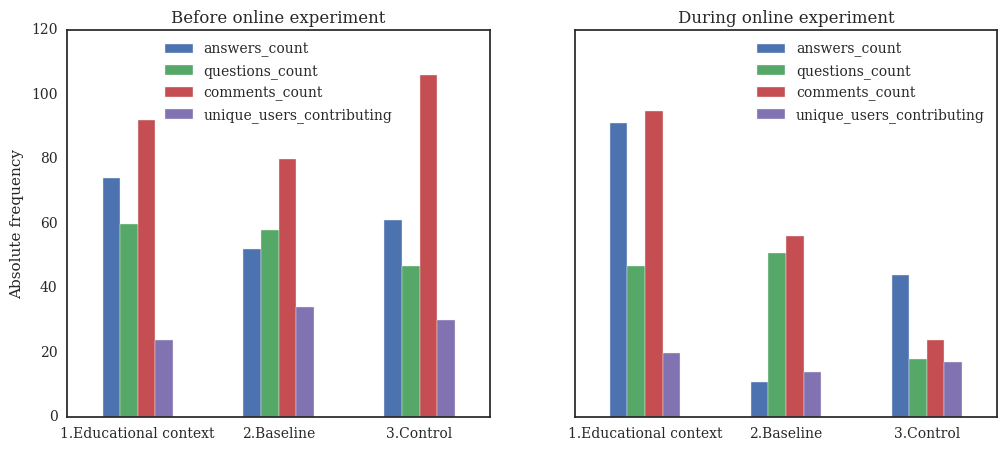

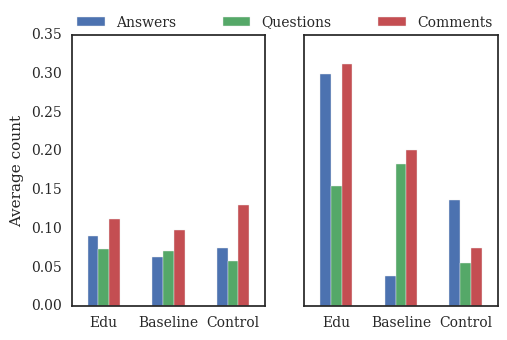

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
start_df.groupby('ab_group')["answers_count", "questions_count", "comments_count", "unique_users_contributing"].sum().plot(ax=ax1, kind="bar", title="Before online experiment", rot=0)
ax1.set(xlabel='', ylabel='Absolute frequency')

end_df.groupby('ab_group')["answers_count", "questions_count", "comments_count", "unique_users_contributing"].sum().plot(ax=ax2, kind="bar", title="During online experiment", rot=0)
ax2.set(xlabel='', ylabel='Absolute frequency')

# Normalization by number of active users
start_df['questions_count_per_user']= start_df['questions_count'] / start_df['unique_users_interacting']
start_df['answers_count_per_user']= start_df['answers_count'] / start_df['unique_users_interacting']
start_df['comments_count_per_user']= start_df['comments_count'] / start_df['unique_users_interacting']
start_df['users_contributing_per_user']= start_df['unique_users_contributing'] / start_df['unique_users_interacting']
end_df['questions_count_per_user']= end_df['questions_count'] / end_df['unique_users_interacting']
end_df['answers_count_per_user']= end_df['answers_count'] / end_df['unique_users_interacting']
end_df['comments_count_per_user']= end_df['comments_count'] / end_df['unique_users_interacting']
end_df['users_contributing_per_user']= end_df['unique_users_contributing'] / end_df['unique_users_interacting']

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
start_df.groupby('ab_group')["answers_count_per_user", "questions_count_per_user", "comments_count_per_user"].sum()\
    .plot(kind="bar", ax=ax1, rot=0, legend=None)
ax1.set(xlabel='', ylabel='Average count')
ax1.set_xticklabels(["Edu", "Baseline", "Control"])
#handles, labels = ax1.get_legend_handles_labels()
#ax1.legend(handles, ["Answers","Questions","Comments"], loc='upper right')

end_df.groupby('ab_group')["answers_count_per_user", "questions_count_per_user", "comments_count_per_user"].sum()\
    .plot(kind="bar", ax=ax2, rot=0)
ax2.set(xlabel='', ylabel='Average count')
ax2.set_xticklabels(["Edu", "Baseline", "Control"])
handles, labels = ax2.get_legend_handles_labels()
#ax2.legend(handles, ["Answers","Questions","Comments"], loc='upper right')
ax2.legend(handles, ["Answers","Questions","Comments"], bbox_to_anchor=(-1.2, 1.0, 2.2, .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
fig.set_size_inches(5.5, 3.5)
fig.savefig('average-counts.eps', format='eps')

**Question recommendation with educational context clearly outperformed baseline approach in contributions.** From average counts per active user during online experiment compared to number of active users during period it is possible to see that question recommendation with educational context clearly outperformed other groups in number of answers and number of comments. 

**Question recommendation involved more users into question answering.** By considering number of contributing users one can see that question recommendation with educational context and baseline approach involved more unique users into contributing compared to the control group. 

Baseline question recommendation has highest number of asked questions.

**Question recommendation has more contibutions in comparison to control group without recommendation.** We consider contribution to question answering by either answering or commenting a question. When we sum number of answers and comments, question recommendation clearly outperformed control group without a recommendation.  

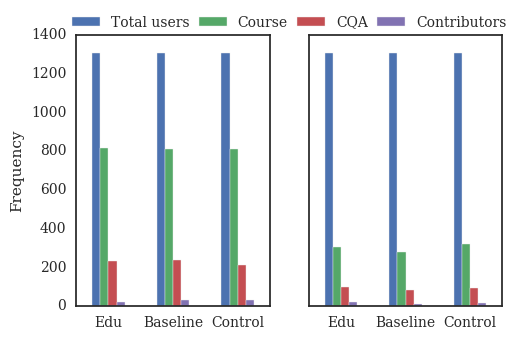

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
start_df.groupby('ab_group')["User count", "unique_users_interacting", "unique_users_using_CQA", "unique_users_contributing"].sum()\
    .plot(kind="bar", ax=ax1, rot=0, legend=None)
ax1.set(xlabel='', ylabel='Frequency')
ax1.set_xticklabels(["Edu", "Baseline", "Control"])
#handles, labels = ax1.get_legend_handles_labels()
#ax1.legend(handles, ["Total","Course","CQA"], loc='upper left')

end_df.groupby('ab_group')["User count","unique_users_interacting", "unique_users_using_CQA", "unique_users_contributing"].sum()\
    .plot(kind="bar", ax=ax2, rot=0)
ax2.set(xlabel='', ylabel='')
ax2.set_xticklabels(["Edu", "Baseline", "Control"])
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, ["Total users","Course","CQA","Contributors"], bbox_to_anchor=(-1.25, 1.0, 2.3, .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.)
fig.set_size_inches(5.5, 3.5)
fig.savefig('active-users.eps', format='eps')

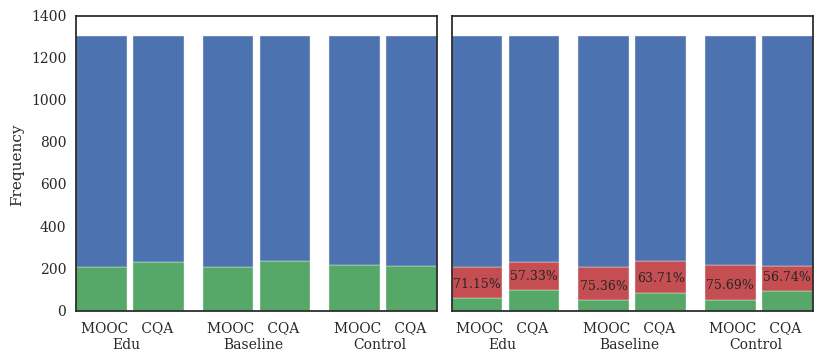

In [18]:
#start_df.groupby('ab_group')[['ab_group','unique_users_mooc', 'unique_users_using_CQA' ,'User count']].sum().plot(kind='bar', stacked=True)
#start_df.groupby('ab_group')['unique_users_mooc', 'User count'].unstack().plot.bar(stacked=True)

# Create a figure with a single subplot
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
bar_width = 1
bar_1 = [0,1,2]
bar_2 = [0.45,1.45,2.45]
tick_pos = [i+0.4 for i in bar_1]
plt.setp((ax1,ax2), xticks=tick_pos, xticklabels=['MOOC   CQA\nEdu','MOOC   CQA\nBaseline','MOOC   CQA\nControl'], ylabel="Frequency")
plt.ylabel("")
ax1.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='x', labelsize=10)
ax1.bar(bar_1,
       start_df['unique_users_mooc'],
       color=sns.color_palette()[1],
       width=0.4,
       )
ax1.bar(bar_1,
       start_df['User count']-start_df['unique_users_mooc'],
       bottom=start_df['unique_users_mooc'],
       color=sns.color_palette()[0],
       width=0.4,
       )
ax1.bar(bar_2,
       start_df['unique_users_using_CQA'],
       color=sns.color_palette()[1],
       width=0.4,
       )
ax1.bar(bar_2,
       start_df['User count']-start_df['unique_users_using_CQA'],
       bottom=start_df['unique_users_using_CQA'],
       color=sns.color_palette()[0],
       width=0.4,
       )
### After
ax2.bar(bar_1,
       end_df['unique_users_mooc'],
       color=sns.color_palette()[1],
       width=0.4
       )
mid_df = start_df['unique_users_mooc']-end_df['unique_users_mooc']
ax2.bar(bar_1,
       mid_df,
       bottom=end_df['unique_users_mooc'],
       color=sns.color_palette()[2],
       width=0.4,
       )
ax2.bar(bar_1,
       end_df['User count']-start_df['unique_users_mooc'],
       bottom=[i+j for i,j in zip(end_df['unique_users_mooc'], mid_df)],
       color=sns.color_palette()[0],
       width=0.4
       )
ax2.bar(bar_2,
       end_df['unique_users_using_CQA'],
       color=sns.color_palette()[1],
       width=0.4
       )
mid_df = start_df['unique_users_using_CQA']-end_df['unique_users_using_CQA']
ax2.bar(bar_2,
       mid_df,
       bottom=end_df['unique_users_using_CQA'],
       color=sns.color_palette()[2],
       width=0.4
       )
ax2.bar(bar_2,
       end_df['User count']-start_df['unique_users_using_CQA'],
       bottom=[i+j for i,j in zip(end_df['unique_users_using_CQA'], mid_df)],
       color=sns.color_palette()[0],
       width=0.4
       )

mooc_dropout_rate = 1-(end_df['unique_users_mooc'] / start_df['unique_users_mooc'])
cqa_dropout_rate = 1-(end_df['unique_users_using_CQA'] / start_df['unique_users_using_CQA'])
for i in range(3):
    ax2.text(bar_1[i]+0.2, end_df['unique_users_mooc'][i]+70, "%.2f%%" % (mooc_dropout_rate[i]*100), ha='center',va='center', fontsize=9)
    ax2.text(bar_2[i]+0.2, end_df['unique_users_using_CQA'][i]+70, "%.2f%%" % (cqa_dropout_rate[i]*100), ha='center',va='center', fontsize=9)

fig.tight_layout()
fig.set_size_inches(8.2, 3.5)
fig.savefig('dropout.eps', format='eps')


### Question recommendation lowered instructors load by 7.8%

In [19]:
prof_answers_before = psql.read_sql("SELECT COUNT(a.author_id) FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id "
                    "JOIN questions q ON q.id=a.question_id WHERE a.created_at < '2016-11-14' AND a.author_id = 4 AND a.deleted=false", connection)
print("Professor answers before online experiment: %d" % prof_answers_before['count'])

TAs = psql.read_sql("""SELECT DISTINCT(user_id) FROM assignments""",connection)

contributions = psql.read_sql("""
    SELECT a.author_id, ab.ab_group_id, a.created_at FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id
    JOIN questions q ON q.id=a.question_id WHERE a.deleted=false
    UNION ALL
    SELECT c.author_id, ab.ab_group_id, c.created_at FROM comments c JOIN ab_groupings ab ON c.author_id = ab.user_id
    WHERE c.deleted=false
    """, connection)

total_end_contributions = answers_end.shape[0] + comments_end.shape[0]
total_before_contributions = answers_start.shape[0] + comments_start.shape[0]

print("Teaching assistants contributions compared to all contributions:")
contributions_before = contributions[(contributions['created_at'] < '2016-11-14') & (contributions['created_at'] > '2016-09-26')]
print("\tbefore online experiment: %.2f%%." % (contributions_before['author_id'].isin(TAs['user_id']).sum()*100 / float(total_before_contributions)))

contributions_end = contributions[(contributions['created_at'] >= '2016-11-14') & (contributions['created_at'] < '2017-01-02')]
print("\tduring online experiment: %.2f%%" % (contributions_end['author_id'].isin(TAs['user_id']).sum()*100 / float(total_end_contributions)))
#contributions_end[~contributions_end['author_id'].isin(TAs['user_id'])]['author_id'].count()

Professor answers before online experiment: 45
Teaching assistants contributions compared to all contributions:
	before online experiment: 38.92%.
	during online experiment: 31.15%


Note: Professor is part of group 1 and he had 45 answers before online experiment (nearly half of answers for group 1), which caused not equal distribution of answers count when splitting users to the groups.  

## Proposed question routing framework has covered 49% of active CQA users. 
Recommendation coverage - how many unique users did get the recommendation? 

Active users are users who have seen at least one question in CQA system.

In [20]:
users_coverage = psql.read_sql("""
    WITH active_users AS (
      SELECT COUNT(*), ab.ab_group_id  from users u JOIN ab_groupings ab ON u.id = ab.user_id 
      WHERE u.views_count > 0 AND ab.ab_group_id != 3 GROUP BY ab.ab_group_id
    )
    SELECT g.value AS ab_group, COUNT(DISTINCT(ab.user_id)) AS total_recommended_to_users, (SELECT count FROM active_users WHERE ab_group_id=g.id) AS total_active_users, 
    COUNT(DISTINCT(ab.user_id)) / (SELECT count FROM active_users WHERE ab_group_id=g.id)::float AS user_coverage FROM notifications as n 
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id
    JOIN ab_groups g ON g.id=ab.ab_group_id
    WHERE n.action = 'recommendation'
    GROUP BY g.id
    """, connection)
display(users_coverage)
print("Total user coverage: %f" % users_coverage['user_coverage'].mean())

,ab_group,total_recommended_to_users,total_active_users,user_coverage
0,1.Educational context,140,283,0.4947
1,2.Baseline,132,264,0.5000


Total user coverage: 0.497350


Both educational context group and baseline group had constrainst on number of recommendation for user per week.

### How educational specific features helps in recommendation

Educational specific features (used only by 1. Educational context recommendation method) displayed are grades and average course acitivity. Knowledge is the sum of number of answers, comments and earned votes. 

Grades, knowledge and average course activity represents values at the end of the course.

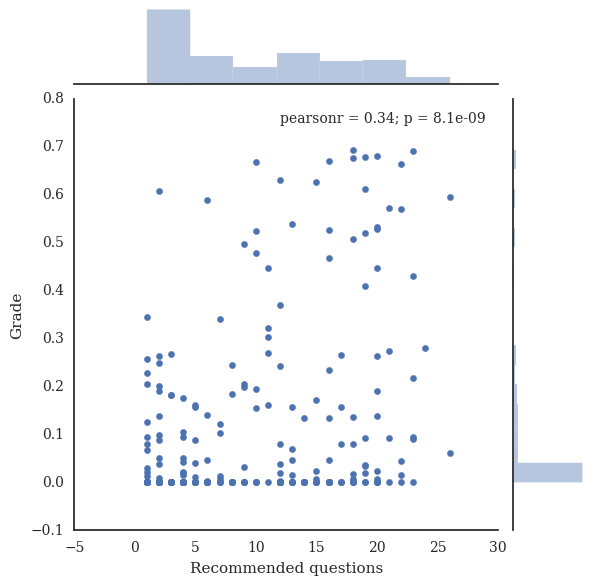

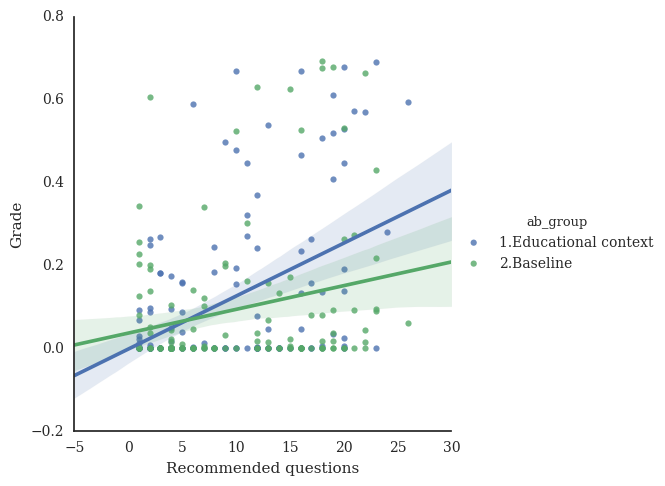

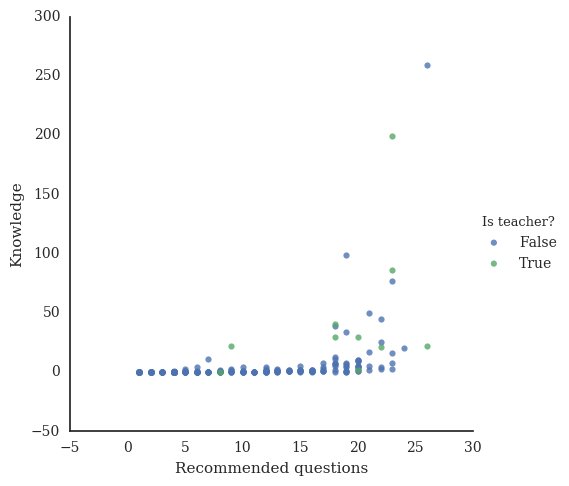

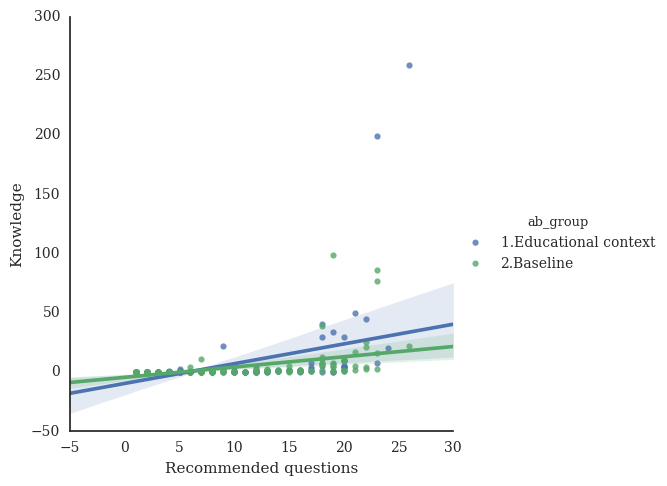

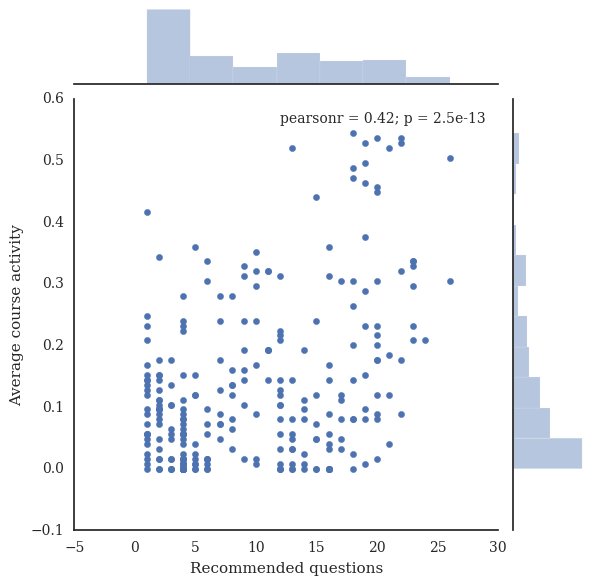

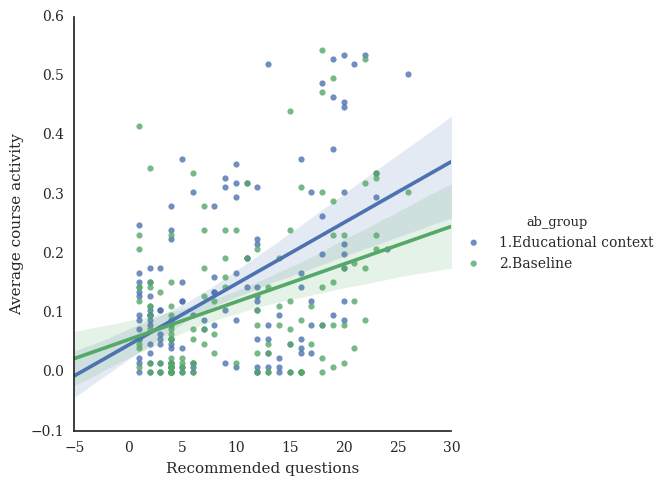

In [21]:
# Grade and number of rec
grades = psql.read_sql("""
    SELECT ab.user_id, g.value AS "ab_group", COUNT(n.id) as "Recommended questions", COALESCE(up.value, 0) AS "Grade" 
    FROM notifications as n
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id
    JOIN ab_groups g ON g.id=ab.ab_group_id
    LEFT JOIN user_profiles up ON (up.user_id = ab.user_id AND up.property='Grade')
    WHERE n.action = 'recommendation'
    GROUP BY ab.user_id, g.id, up.value
""", connection)
sns.jointplot(x="Recommended questions", y="Grade", data=grades)
sns.lmplot(x="Recommended questions", y="Grade", hue="ab_group", data=grades, fit_reg=True)

knowledge = psql.read_sql("""
    SELECT ab.user_id, g.value AS "ab_group", COUNT(n.id) as "Recommended questions", COALESCE(up.value, 0) AS "Knowledge", exists (select true from assignments where user_id=ab.user_id) AS "Is teacher?"
    FROM notifications as n
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id
    JOIN ab_groups g ON g.id=ab.ab_group_id
    LEFT JOIN user_profiles up ON (up.user_id = ab.user_id AND up.property='Knowledge')
    WHERE n.action = 'recommendation'
    GROUP BY ab.user_id, g.id, up.value
    """, connection)
sns.lmplot(x="Recommended questions", y="Knowledge", hue="Is teacher?", data=knowledge, fit_reg=False)
sns.lmplot(x="Recommended questions", y="Knowledge", hue="ab_group", data=knowledge)

avg_course_activity = psql.read_sql("""
SELECT ab.user_id, g.value AS "ab_group", COUNT(n.id) as "Recommended questions", COALESCE(up.value, 0) AS "Average course activity" 
FROM notifications as n
JOIN ab_groupings ab ON ab.user_id = n.recipient_id
JOIN ab_groups g ON g.id=ab.ab_group_id
LEFT JOIN user_profiles up ON (up.user_id = ab.user_id AND up.property='AvgCourseActivity')
WHERE n.action = 'recommendation'
GROUP BY ab.user_id, g.id, up.value
ORDER BY g.id
    """, connection)
sns.jointplot(x="Recommended questions", y="Average course activity", data=avg_course_activity)
sns.lmplot(x="Recommended questions", y="Average course activity", hue="ab_group", data=avg_course_activity)

### Student examples of how features are related to number of recommended questions

In [22]:
students_examples = psql.read_sql("""
    SELECT DISTINCT ab.user_id, ab.ab_group_id, COUNT(n.id) as "Number of recommended questions", property, value
    FROM notifications as n 
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id
    JOIN user_profiles up ON (up.user_id = ab.user_id)
    WHERE n.action = 'recommendation' AND up.targetable_id = -1
    AND ab.user_id IN (17, 2298)
    GROUP BY ab.ab_group_id, ab.user_id, property, value
    ORDER BY ab.user_id
""", connection)
display(students_examples.ix[:5])
students_examples.ix[7:13]

,user_id,ab_group_id,Number of recommended questions,property,value
0,17,1,16,AvgCourseActivity,0.360000
1,17,1,16,AvgCqaActivity,0.224000
2,17,1,16,CommentsCount,1.000000
3,17,1,16,Grade,0.669766
4,17,1,16,Knowledge,1.000000
5,17,1,16,QuestionCount,1.000000


,user_id,ab_group_id,Number of recommended questions,property,value
7,2298,1,20,AnswersVotesCount,1.00000
8,2298,1,20,AvgCourseActivity,0.45600
9,2298,1,20,AvgCqaActivity,0.21600
10,2298,1,20,Grade,0.67975
11,2298,1,20,Knowledge,1.00000
12,2298,1,20,QuestionCount,2.00000
13,2298,1,20,QuestionVotesCount,1.00000


In the tables above are interesting examples of two students from groups with educational specific recommendation (ab_group_id = 1). 

Student 2218 had one contribution in the CQA system, i.e. one comment. However, question recommendation routed 13 question to him/her as the average activity in course and grades are high for him/her.

Student 2298 had only two contribution in the CQA system, i.e. two questions. However, educational specific question recommendation routed 18 questions to him/her as his/her average activity in course and grades are high. Moreover, in our analysis we discovered that this student is from TU Delft and did this course as a part of his university studies.

Without considering non-QA specific features from the course, these users would not be ranked as experts and fewer questions would be recommended to them. However, they were not willing to share their knowledge.

### Knowledge gap is positive in overall (median = 7) i.e. answerers have higher knowledge than askers 
Knowledge gaps data sets are created by Askalot evaluation infrastructure because the knowledge gap between asker of the question and answerer was changing over time.

count    378.000000
mean      18.039683
std       44.959410
min     -167.000000
25%        0.000000
50%        7.000000
75%       34.750000
max      166.000000
Name: Knowledge gap, dtype: float64

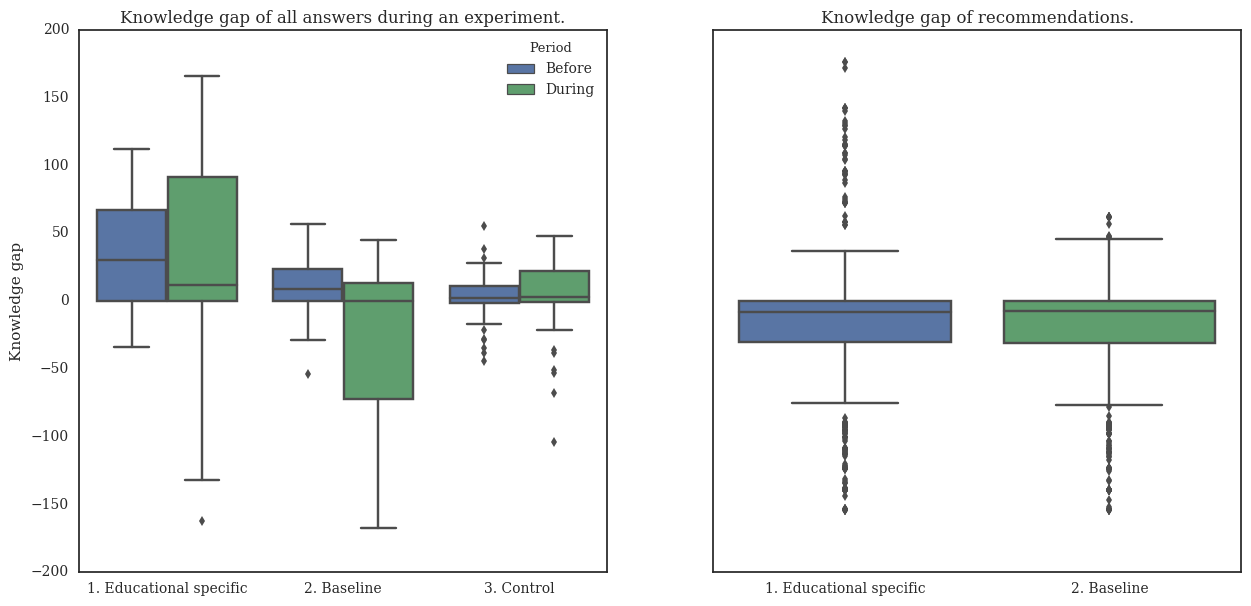

In [23]:
kgaps = pd.read_csv('data/full/kgaps.txt', delimiter=' ', header=None, names = ['Answerer ab_group', 'Knowledge gap', 'Period'])
kgaps['Period'] = np.where(kgaps['Period'] == 1, 'During', 'Before')
kgaps['Answerer ab_group'].replace({1:'1. Educational specific',2:'2. Baseline', 3:'3. Control'},inplace=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,7))
sns.boxplot(x="Answerer ab_group", y="Knowledge gap", hue="Period", data=kgaps, ax=ax1, order=["1. Educational specific", "2. Baseline", "3. Control"])
ax1.set_title('Knowledge gap of all answers during an experiment.')
ax1.set(xlabel='', ylabel='Knowledge gap')

kgaps_rec = pd.read_csv('data/full/rec_kgaps.txt', delimiter=' ', header=None, names = ['Answerer ab_group', 'Knowledge gap', 'Period'])
kgaps_rec['Answerer ab_group'].replace({1:'1. Educational specific',2:'2. Baseline', 3:'3. Control'},inplace=True)
sns.boxplot(x="Answerer ab_group", y="Knowledge gap", data=kgaps_rec, ax=ax2, order=["1. Educational specific", "2. Baseline"])
ax2.set_title('Knowledge gap of recommendations.')
ax2.set(xlabel='', ylabel='')

kgaps["Knowledge gap"].describe()

## Question recommendation preserves question answering success rate
Question answering success rate is number of questions with at least one answer.

Note: Only questions are considered, not discussions and bug reports.

In [33]:
questions_before = psql.read_sql("""
            SELECT q.id, q.title, COUNT(a.id) AS answers_count FROM questions q 
            LEFT JOIN answers a ON (a.question_id=q.id AND a.created_at < '2016-11-14' AND a.created_at >= '2016-09-26' AND a.deleted=false)
            WHERE q.created_at < '2016-11-14' AND q.created_at >= '2016-09-26' AND question_type_id = 1 
            AND q.deleted=false 
            GROUP BY q.id
            """,connection)

questions_during = psql.read_sql("""
            SELECT q.id, q.title, COUNT(a.id) AS answers_count FROM questions q 
            LEFT JOIN answers a ON (a.question_id=q.id AND a.created_at >= '2016-11-14' AND a.created_at <= '2017-01-02' AND a.deleted=false)
            WHERE q.created_at >= '2016-11-14' AND q.created_at <= '2017-01-02' AND question_type_id = 1
            AND q.deleted=false
            GROUP BY q.id
            """,connection)
before_success_rate = (questions_before['answers_count'] != 0).sum()*100 / float(len(questions_before))
during_success_rate = (questions_during['answers_count'] != 0).sum()*100 / float(len(questions_during))

print("Success rate before online experiment: %.3f %%" % before_success_rate)
print("Success rate during online experiment: %.3f %%" % during_success_rate)

Success rate before online experiment: 85.577 %
Success rate during online experiment: 84.211 %


### Average answer quality was preserved with the question recommendation
Quality of answers is estimated by number of earned votes for a particular answer.

In [25]:
quality = psql.read_sql("""
            SELECT (SELECT AVG(a.votes_difference) FROM answers a
            JOIN questions q ON q.id=a.question_id
            WHERE a.created_at < '2016-11-14' AND a.created_at >= '2016-09-26' AND a.deleted=false) 
            as quality_before, 
            (SELECT AVG(a.votes_difference) FROM answers a
            JOIN questions q ON q.id=a.question_id
            WHERE a.created_at >= '2016-11-14' AND a.created_at <= '2017-01-02' AND a.deleted=false)
            as quality_during
          """, connection)
quality

,quality_before,quality_during
0,0.452514,0.56


In [26]:
not_rec_answers= psql.read_sql("""
        SELECT g.value as "ab_group", a.id, a.votes_difference FROM answers a
        JOIN questions q ON q.id=a.question_id
        JOIN ab_groupings ab ON a.author_id=ab.user_id
        JOIN ab_groups g ON g.id=ab.ab_group_id
        WHERE a.created_at >= '2016-11-14' AND a.created_at <= '2017-01-02' AND a.deleted=false
        """, connection)

not_rec_answers = not_rec_answers[~not_rec_answers['id'].isin(answers_success_rec['id'].unique())]
not_rec_answers_by_groups = not_rec_answers.groupby('ab_group')['votes_difference'].agg(['count', 'mean']).reset_index()
not_rec_answers_by_groups.rename(columns = {'mean':'Average votes of answers for not recommended questions during online experiment', 'count': 'Answer count'}, inplace = True)
display(not_rec_answers_by_groups)

answers_success_rec_groups = pd.merge(answers_success_rec, ab_groups, on="ab_group_id")
rec_by_groups = answers_success_rec_groups.groupby('Name')['votes_difference'].agg(['count', 'mean']).reset_index()
rec_by_groups.rename(columns = {'mean':'Average votes of answers for recommended question during online experiment', 'count': 'Answer count'}, inplace = True)
display(rec_by_groups)

,ab_group,Answer count,Average votes of answers for not recommended questions during online experiment
0,1.Educational context,75,0.666667
1,2.Baseline,9,1.000000
2,3.Control,43,0.348837


,Name,Answer count,Average votes of answers for recommended question during online experiment
0,1.Educational context,15,0.6
1,2.Baseline,2,0.5


Answers of users from baseline group has highest votes value, however it has few total number of answers.

Average votes value is higher for answers to recommended questions, but it lacks more data. Note: Only answers can be voted.

### Average time to answer increased with a recommendation

In [27]:
before_answers_time = psql.read_sql("""
            SELECT q.id, q.created_at, MIN(a.created_at) AS first_answer_time FROM questions q
            JOIN answers a ON (a.question_id=q.id AND a.created_at < '2016-11-14' AND a.created_at >= '2016-09-26')
            WHERE q.created_at < '2016-11-14' AND q.created_at >= '2016-09-26' AND q.deleted=false
            GROUP BY q.id
            """,connection)

during_answers_time = psql.read_sql("""
            SELECT q.id, q.created_at, MIN(a.created_at) AS first_answer_time FROM questions q
            JOIN answers a ON (a.question_id=q.id AND a.created_at >= '2016-11-14' AND a.created_at <= '2017-01-02')
            WHERE q.created_at >= '2016-11-14' AND q.created_at <= '2017-01-02' AND q.deleted=false
            GROUP BY q.id
            """,connection)

print("Average time to answer:")
avg_time_before = (before_answers_time['first_answer_time'] - before_answers_time['created_at']).sum() / len(before_answers_time) 
print("\tbefore online experiment: %s" % avg_time_before)

avg_time_during = (during_answers_time['first_answer_time'] - during_answers_time['created_at']).sum() / len(during_answers_time)
print("\tduring online experiment: %s" % avg_time_during)

print("Average time to answer increased with question recommendation by: %s" % (avg_time_during - avg_time_before))

during_answer_time_by_groups = psql.read_sql("""
        SELECT q.id, q.created_at, a.author_id, a.created_at AS first_answer_time, ab.ab_group_id, g.value as "ab_group"
        FROM questions q
        JOIN (  SELECT id, author_id, question_id, created_at, rank() OVER ( 
                PARTITION BY question_id ORDER BY created_at ASC) FROM answers
        ) AS a ON (a.question_id=q.id AND a.rank = 1 AND a.created_at >= '2016-11-14' AND a.created_at <= '2017-01-02')
        JOIN ab_groupings ab ON a.author_id=ab.user_id
        JOIN ab_groups g ON g.id=ab.ab_group_id
        WHERE q.created_at >= '2016-11-14' AND q.created_at <= '2017-01-02' AND q.deleted=false
        """, connection)
during_answer_time_by_groups['time_diff'] = during_answer_time_by_groups['first_answer_time'] - during_answer_time_by_groups['created_at']
during_answer_time_by_groups['time_diff'] = during_answer_time_by_groups['time_diff'].astype('timedelta64[h]')
during_answer_time_by_groups = during_answer_time_by_groups.groupby('ab_group')['time_diff'].agg(['count', 'mean']).reset_index()
during_answer_time_by_groups.rename(columns = {'mean':'Average time to answer', 'count': 'Answer count'}, inplace = True)
#during_answer_time_by_groups['Average time to answer'] = during_answer_time_by_groups['Average time to answer'].astype('timedelta')
display(during_answer_time_by_groups)

success_rec['time_to_response'] = success_rec['r_created_at'] - success_rec['n_created_at']
success_rec['time_to_response'] = success_rec['time_to_response'].astype('timedelta64[h]')
recs_time_by_groups = success_rec.groupby('Name')['time_to_response'].agg(['count', 'mean']).reset_index()
recs_time_by_groups.rename(columns = {'mean':'Average time to answer for successfuly answered recommendations', 'count': 'Answer count'}, inplace = True)
recs_time_by_groups

Average time to answer:
	before online experiment: 0 days 21:25:09.237297
	during online experiment: 1 days 15:08:59.701464
Average time to answer increased with question recommendation by: 0 days 17:43:50.464167


,ab_group,Answer count,Average time to answer
0,1.Educational context,64,33.750000
1,2.Baseline,7,32.571429
2,3.Control,28,52.714286


,Name,Answer count,Average time to answer for successfuly answered recommendations
0,1.Educational context,22,43.863636
1,2.Baseline,6,55.333333


Average time to answer increased during the online experiment. However, it might be related with higher difficulty of the course and less number of active users. Therefore, time to answer in groups is more relevant. **Users with recommendation (baseline, educational context) has significantly lower average time in total to answer than control group by 6 and 16 hours.** However, for the successfuly answered recommendations the difference is lower.

Note: Only first answer for a question is considered.

### Contributing users for each week compared to active users in a week did not change
Contribution is defined as asking, answering and commenting. Active user is a user who saw any question during a particular week.

,weekly,Contributing users,Active users,Contributing to active portion
0,2016-09-26 00:00:00+02:00,15,136,11.029412
1,2016-10-03 00:00:00+02:00,19,145,13.103448
2,2016-10-10 00:00:00+02:00,48,1661,2.889825
3,2016-10-17 00:00:00+02:00,52,919,5.658324
4,2016-10-24 00:00:00+02:00,36,730,4.931507
5,2016-10-31 00:00:00+01:00,26,614,4.234528
6,2016-11-07 00:00:00+01:00,21,513,4.093567


,weekly,Contributing users,Active users,Contributing to active portion
6,2016-11-07 00:00:00+01:00,21,513,4.093567
7,2016-11-14 00:00:00+01:00,23,535,4.299065
8,2016-11-21 00:00:00+01:00,27,478,5.648536
9,2016-11-28 00:00:00+01:00,23,617,3.727715
10,2016-12-05 00:00:00+01:00,21,463,4.535637
11,2016-12-12 00:00:00+01:00,31,545,5.688073
12,2016-12-19 00:00:00+01:00,19,343,5.539359
13,2016-12-26 00:00:00+01:00,8,220,3.636364


Recommendation effect size: -1.517


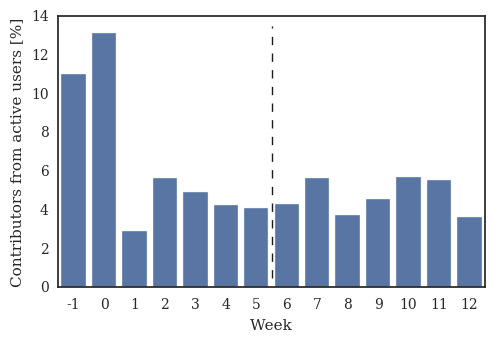

In [28]:
contributing_users = psql.read_sql("""
    SELECT date_trunc('week', a.created_at::date) AS weekly, COUNT(DISTINCT(a.initiator_id)) as "Contributing users"
    FROM activities a
    WHERE a.resource_type IN ('Shared::Question', 'Shared::Answer', 'Shared::Comment')
    AND a.created_at > '2016-09-26' AND a.created_at < '2017-01-01' AND a.action='create'
    GROUP BY weekly
    ORDER BY weekly
          """, connection)
active_users = psql.read_sql("""
    SELECT date_trunc('week', a.created_at::date) AS weekly, COUNT(DISTINCT(a.initiator_id)) as "Active users" 
    FROM activities a
    WHERE a.created_at > '2016-09-26' AND a.created_at < '2017-01-01' AND a.action='create'
    GROUP BY weekly
    ORDER BY weekly
          """, connection)
users = pd.merge(contributing_users, active_users, on='weekly', how='inner')
users['Contributing to active portion'] = users['Contributing users']*100 / users['Active users']
display(users.ix[:6])
display(users.ix[6:])

print("Recommendation effect size: %.3f" % (users.ix[6:]['Contributing to active portion'].mean() - users.ix[1:5]['Contributing to active portion'].mean()))

fig = plt.figure()
ax= sns.barplot(y='Contributing to active portion', x=np.arange(-1,13), data=users, color=sns.color_palette()[0])
ax.vlines(6.5, 0.5, 13.5, linestyle='--', linewidth=1)
ax.set(xlabel='Week', ylabel='Contributors from active users [%]')
fig.set_size_inches(5.5, 3.5)
fig.savefig('course-contributing-activity.eps', format='eps')

## Anova

In [29]:
df = psql.read_sql("""
    SELECT a.author_id, ab.ab_group_id, a.votes_difference, (a.created_at - q.created_at) as "time to answer" FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id
    JOIN questions q ON q.id=a.question_id 
    WHERE q.created_at >= '2016-11-14'
    """, connection)
df['time to answer'] = df['time to answer'].astype('timedelta64[m]')

full_rec_group = df[df['ab_group_id'] == 1].copy().reset_index()
baseline_rec_group = df[df['ab_group_id'] == 2].copy().reset_index()
control_group = df[df['ab_group_id'] == 3].copy().reset_index()

print("Votes difference: \t\t\tEducational %.3f \tBaseline %.3f \t\t\tControl %.3f" % (full_rec_group['votes_difference'].mean(), baseline_rec_group['votes_difference'].mean(), control_group['votes_difference'].mean()))
print("Time to answer difference[in hours]: \tEducational %.3f \tBaseline %.3f \t\tControl %.3f" % (full_rec_group['time to answer'].mean(), baseline_rec_group['time to answer'].mean(), control_group['time to answer'].mean()))

display(stats.ttest_ind(full_rec_group['votes_difference'], control_group['votes_difference']))
display(stats.ttest_ind(full_rec_group['time to answer'], control_group['time to answer']))
#stats.f_oneway(full_rec_group, baseline_rec_group, control_group)
len(baseline_rec_group)

Votes difference: 			Educational 0.670 	Baseline 0.900 			Control 0.341
Time to answer difference[in hours]: 	Educational 3562.898 	Baseline 1948.800 		Control 4889.244


Ttest_indResult(statistic=1.4921937046762368, pvalue=0.1381283275774137)

Ttest_indResult(statistic=-1.0976126964032198, pvalue=0.27445034825018921)

10

Answer quality and time to first answers was preserved during online experiment.


## Summary course statistics

In [30]:
best_answers = psql.read_sql("SELECT * FROM labelings ls JOIN labels l ON l.id=ls.label_id WHERE l.value='best'", 
                             connection)
users_count = psql.read_sql("SELECT COUNT(*) FROM users", connection)
users_with_view_count = psql.read_sql("SELECT COUNT(*) FROM users WHERE views_count > 0", connection)
contributing_users_count = psql.read_sql("SELECT COUNT(*) FROM users WHERE answers_count > 0 OR comments_count > 0 OR questions_count > 0", connection)
evaluations_count = psql.read_sql("SELECT COUNT(*) FROM evaluations", connection)

print("Overall questions count: \t%d" % (questions_start.shape[0] + questions_end.shape[0]))
print("\twith any answer: \t%d" % (pd.concat([answers_start, answers_end])['id'].unique().size))
print("\twith best answer: \t%d" % (best_answers.shape[0]))
print("Overall answers count: \t\t%d" % (answers_start.shape[0] + answers_end.shape[0]))
print("Overall users count: \t\t%d" % (users_count['count']))
print("\twith any question view: %d" % (users_with_view_count['count']))
print("\twith any question view: %d" % (contributing_users_count['count']))
print("Overall teachers evaluations: \t%d" % (evaluations_count['count']))

Overall questions count: 	281
	with any answer: 	246
	with best answer: 	61
Overall answers count: 		333
Overall users count: 		4685
	with any question view: 872
	with any question view: 170
Overall teachers evaluations: 	26
